# Lesson 12 : Association Rule Mining - Market Basket Analysis with Mlxtend

# 1. Intro

**Have you ever considered the techniques behind the online recommendation systems or product placement strategies ?** <br><br>
**If your answer is 'Yes', you are definetely at right place !**

<img width="1000" height="400" alt="netflix" align="left" src="https://user-images.githubusercontent.com/36535914/78720348-369df700-792e-11ea-9950-8f5731409171.png">
***

Association rule learning is a rule-based machine learning method for discovering relations between variables in large databases. Goal is to identify strong relations discovered in datasets using some measures such as confidence or lift.

An association rule is an implication expression of the form X→Y, where X and Y are seperate itemsets. A more concrete example based on consumer behaviour would be {Diapers}→{Beer} suggesting that people who buy diapers are also likely to buy beer. To evaluate the "interest" of such an association rule, different metrics have been developed. The current implementation make use of the confidence and lift metrics as which we just mentioned above

- ***If a customer buys bread, he’s 70% likely of buying milk***

In the above association rule, bread is the antecedent and milk is the consequent. Simply put, it can be understood as a retail store’s association rule to target their customers better. If the above rule is a result of a thorough analysis of some data sets, it can be used to not only improve customer service but also improve the company’s revenue.

Additional to above the association rule based learning techniques are also used in many applications such as recommendation systems, medical diagnosis, protein sequence, census data or even crime prevention, [click here for details ](https://www.upgrad.com/blog/most-common-examples-of-data-mining/)

The Apriori algorithm is one of the main technique of association rule mining, which can be basically descibed as finding the most frequent itemsets in a dataset. We will be using that algorithm as well in our tutorial.

So, keep reading for details ! 

# 2. Data Load

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
path = "/home/pep/drive/PCLOUD/VTCA/2-AI-Specialist/AI_Workspace/3-Dataset/AI Specialist Lesson 12"
import os
os.chdir(path)

In [3]:
data = pd.read_csv("Market_Basket_Optimisation.csv", header=None)
data.shape

(7501, 20)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [6]:
data[1]

0                 almonds
1               meatballs
2                     NaN
3                 avocado
4                    milk
              ...        
7496           light mayo
7497    frozen vegetables
7498                  NaN
7499            green tea
7500      frozen smoothie
Name: 1, Length: 7501, dtype: object

# 3. Data Visualizations

***- The most demanded items in dataset / Top10***

In [7]:
# 1. Gather All Items of Each Transactions into Numpy Array
transaction = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        transaction.append(data.values[i,j])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df = pd.DataFrame(transaction, columns=["items"]) 
df["incident_count"] = 1 # Put 1 to Each Item For Making Countable Table, to be able to perform Group By

# 3. Delete NaN Items from Dataset
indexNames = df[df['items'] == "nan" ].index
df.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations  
df_table = df.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()

# 5. Initial Visualizations
df_table.head(10).style.background_gradient(cmap='Blues')

,items,incident_count
0,mineral water,1788
1,eggs,1348
2,spaghetti,1306
3,french fries,1282
4,chocolate,1230
5,green tea,991
6,milk,972
7,ground beef,737
8,frozen vegetables,715
9,pancakes,713


***- The most demanded items in dataset / Top30***

In [8]:
df_table["all"] = "all" # to have a same origin

fig = px.treemap(df_table.head(30), path=['all', "items"], values='incident_count',
                  color=df_table["incident_count"].head(30), hover_data=['items'],
                  color_continuous_scale='Blues',
                  )
fig.show()

/home/pep/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/pep/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



***- Lets check whether the items have multiple records in a transaction or not***<br>
***- If the answer is "Yes", we need to handle them since they might mislead the apriori algorithm in further steps***

In [10]:
# Transform Every Transaction to Seperate List & Gather Them into Numpy Array
# By Doing So, We Will Be Able To Iterate Through Array of Transactions

transaction = []
for i in range(data.shape[0]):
    transaction.append([str(data.values[i,j]) for j in range(data.shape[1])])
    
transaction = np.array(transaction)

# Create a DataFrame In Order To Check Status of Top20 Items

top20 = df_table["items"].head(20).values
array = []
df_top20_multiple_record_check = pd.DataFrame(columns=top20)

for i in range(0, len(top20)):
    array = []
    for j in range(0,transaction.shape[0]):
        array.append(np.count_nonzero(transaction[j]==top20[i]))
        if len(array) == len(data):
            df_top20_multiple_record_check[top20[i]] = array
        else:
            continue
            

df_top20_multiple_record_check.head(10)

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,burgers,cake,cookies,escalope,low fat yogurt,shrimp,tomatoes,olive oil,frozen smoothie,turkey
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_top20_multiple_record_check.describe()

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,burgers,cake,cookies,escalope,low fat yogurt,shrimp,tomatoes,olive oil,frozen smoothie,turkey
count,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000
mean,0.238368,0.179709,0.174110,0.170911,0.163978,0.132116,0.129583,0.098254,0.095321,0.095054,0.087188,0.081056,0.080389,0.079323,0.076523,0.071457,0.068391,0.065858,0.063325,0.062525
std,0.426114,0.383971,0.379229,0.376456,0.370640,0.338639,0.335866,0.297677,0.293677,0.293309,0.282130,0.272939,0.271913,0.270260,0.265851,0.257604,0.252432,0.248050,0.243563,0.242123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- ***As you see above, only Chocolate has a max value of 2. The others have max value of 1. From that reason we can say that the data is homogenous, we can proceed without any inference.***

***- Choice Analysis / Customers' First Choices***

In [12]:
# 1. Gather Only First Choice of Each Transactions into Numpy Array
# Similar Pattern to Above, Only Change is the Column Number "0" in Append Function
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,0])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_first = pd.DataFrame(transaction, columns=["items"])
df_first["incident_count"] = 1

# 3. Delete NaN Items from Dataset
indexNames = df_first[df_first['items'] == "nan" ].index
df_first.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations  
df_table_first = df_first.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_first["food"] = "food"
df_table_first = df_table_first.truncate(before=-1, after=15) # Fist 15 Choice


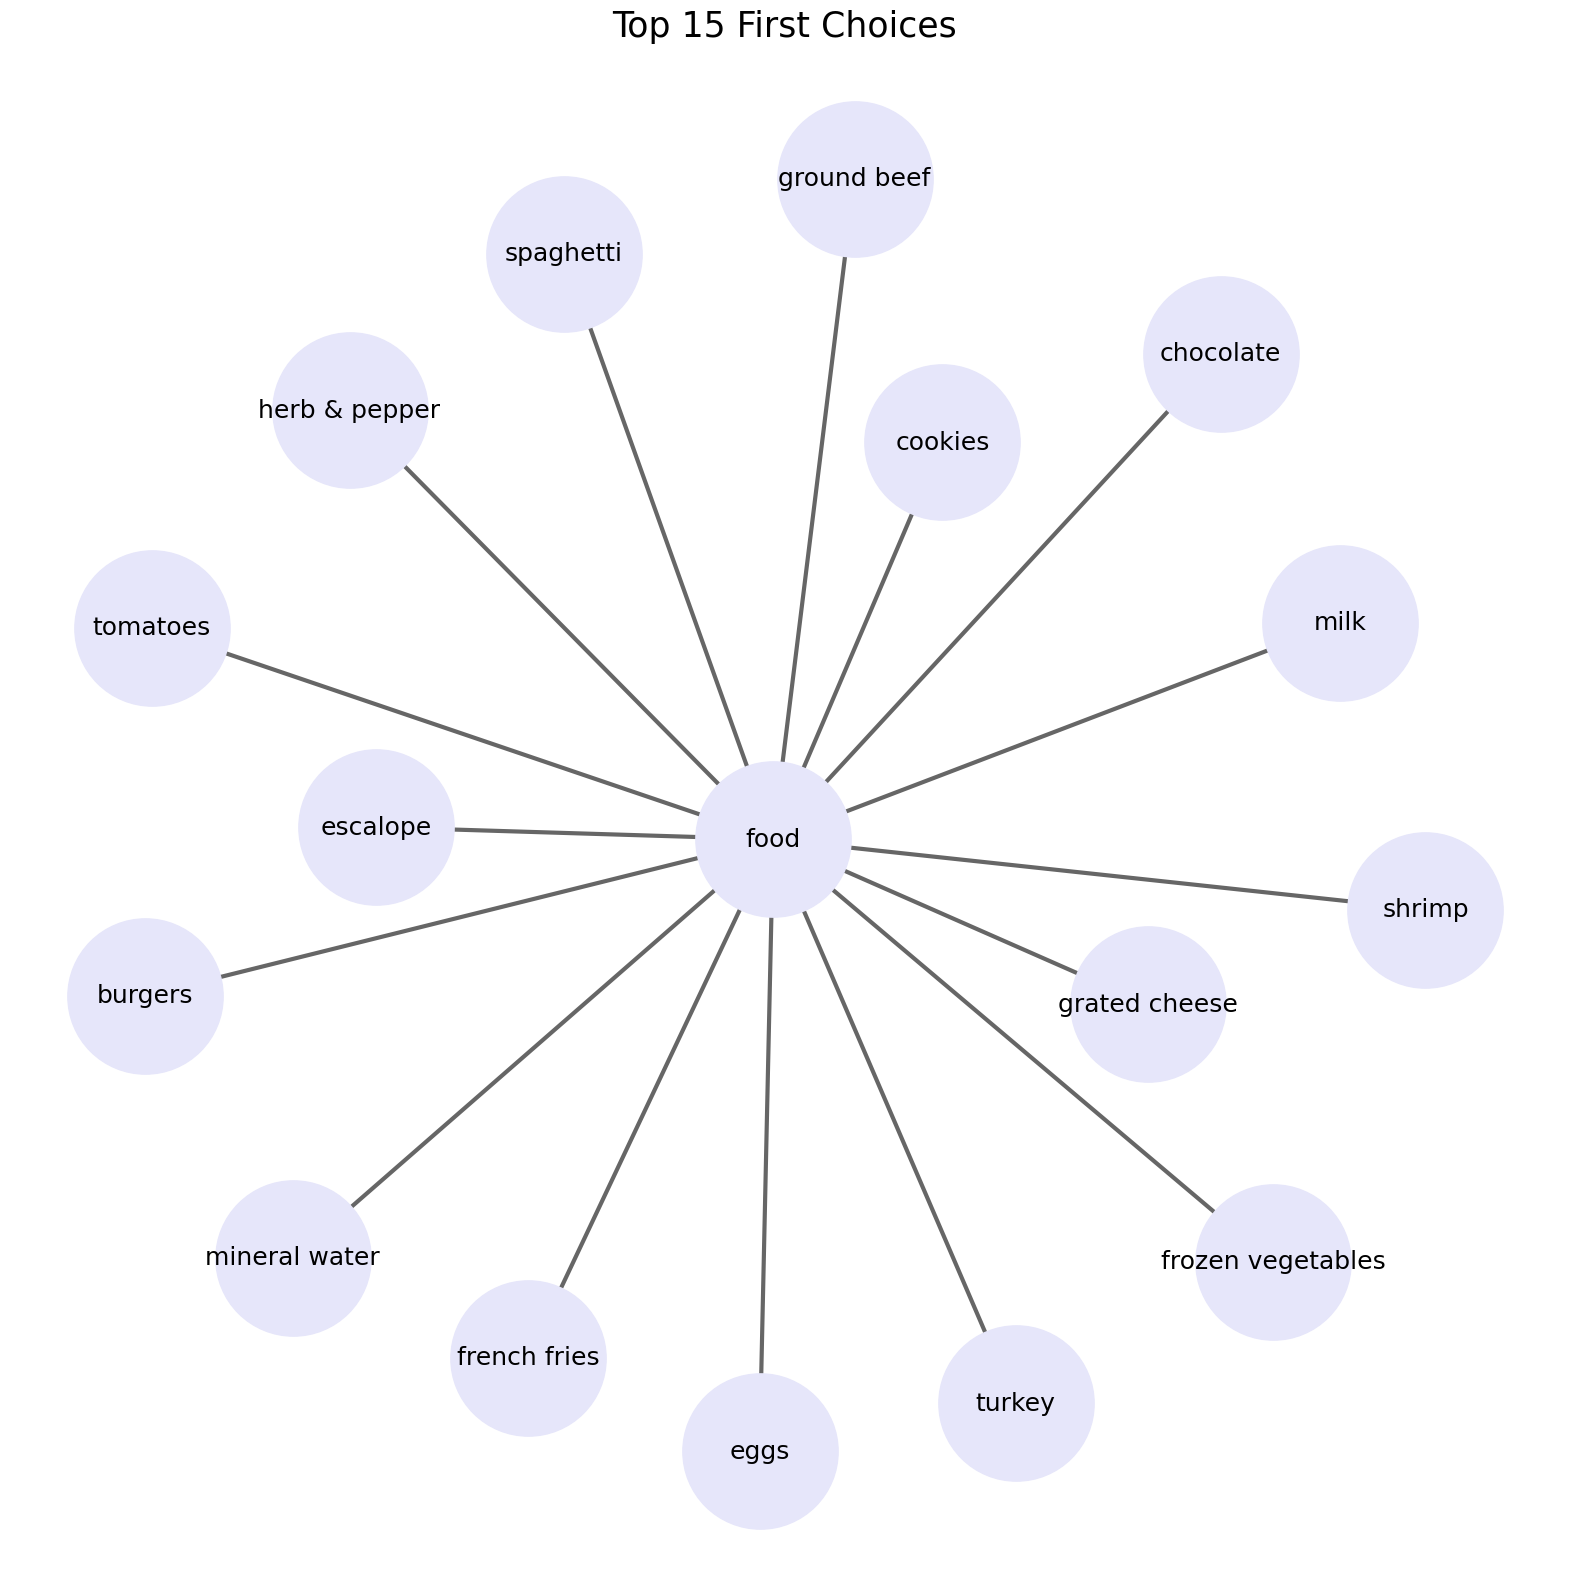

In [11]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 20)
first_choice = nx.from_pandas_edgelist(df_table_first, source = 'food', target = "items", edge_attr = True)
pos = nx.spring_layout(first_choice)
nx.draw_networkx_nodes(first_choice, pos, node_size = 12500, node_color = "lavender")
nx.draw_networkx_edges(first_choice, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(first_choice, pos, font_size = 18, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 First Choices', fontsize = 25)
plt.show()

***- Choice Analysis / Customers' Second Choices***

In [13]:
# 1. Gather Only Second Choice of Each Transaction into Numpy Array

transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,1])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_second = pd.DataFrame(transaction, columns=["items"]) 
df_second["incident_count"] = 1

# 3. Delete NaN Items from Dataset
indexNames = df_second[df_second['items'] == "nan" ].index
df_second.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations  
df_table_second = df_second.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_second["food"] = "food"
df_table_second = df_table_second.truncate(before=-1, after=15) # Fist 15 Choice


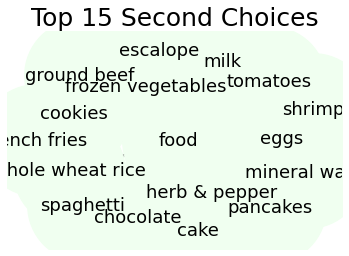

In [14]:
import warnings
warnings.filterwarnings('ignore')

second_choice = nx.from_pandas_edgelist(df_table_second, source = 'food', target = "items", edge_attr = True)
pos = nx.spring_layout(second_choice)
nx.draw_networkx_nodes(second_choice, pos, node_size = 12500, node_color = "honeydew")
nx.draw_networkx_edges(second_choice, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(second_choice, pos, font_size = 18, font_family = 'sans-serif')
plt.rcParams['figure.figsize'] = (20, 20)
plt.axis('off')
plt.grid()
plt.title('Top 15 Second Choices', fontsize = 25)
plt.show()

***- Choice Analysis / Customers' Third Choices***

In [15]:
# 1. Gather Only Third Choice of Each Transaction into Numpy Array
## For Column "2"
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,2])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_third = pd.DataFrame(transaction, columns=["items"]) # Transaction Item Name
df_third["incident_count"] = 1 # Put 1 to Each Item For Making Countable Table, Group By Will Be Done Later On

# 3. Delete NaN Items from Dataset
indexNames = df_third[df_third['items'] == "nan" ].index
df_third.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations  
df_table_third = df_third.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_third["food"] = "food"
df_table_third = df_table_third.truncate(before=-1, after=15) # Fist 15 Choice


In [16]:
fig = go.Figure(data=[go.Bar(x=df_table_third["items"], y=df_table_third["incident_count"],
            hovertext=df_table_third["items"], text=df_table_third["incident_count"], textposition="outside")])

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.65)
fig.update_layout(title_text="Customers' Third Choices", template="plotly_dark")
fig.show()

# 4. Data Pre-Processing

***In order to be able to use apriori algorithm and get most frequent itemsets, we have to transform our dataset into a 1 – 0 matrix where rows are transactions and columns are products. In that matrix, “1” should be encoded if the product has been bought on that transaction and “0” should be encoded if the product has not been bought on that transaction. This preprocessing is required for use of the algorithm.***


http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/ <br>
http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/


In [17]:
# Transform Every Transaction to Seperate List & Gather Them into Numpy Array

transaction = []
for i in range(data.shape[0]):
    transaction.append([str(data.values[i,j]) for j in range(data.shape[1])])
    
transaction = np.array(transaction)
transaction

array([['shrimp', 'almonds', 'avocado', ..., 'frozen smoothie',
        'spinach', 'olive oil'],
       ['burgers', 'meatballs', 'eggs', ..., 'nan', 'nan', 'nan'],
       ['chutney', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ...,
       ['chicken', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['escalope', 'green tea', 'nan', ..., 'nan', 'nan', 'nan'],
       ['eggs', 'frozen smoothie', 'yogurt cake', ..., 'nan', 'nan',
        'nan']], dtype='<U20')

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
dataset = pd.DataFrame(te_ary, columns=te.columns_)
dataset

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7497,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7498,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7499,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
dataset.shape

(7501, 121)

***We have 121 columns/features at the moment. Extracting the most frequent itemsets from 121 feature would be compelling for a start*** <br>
***From that reason, we will start with Top 50 items which are already illustrated in Section-3***



In [20]:
first50 = df_table["items"].head(50).values # Select Top50
dataset = dataset.loc[:,first50] # Extract Top50
dataset

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,...,ham,energy bar,energy drink,pepper,vegetables mix,cereals,muffins,oil,french wine,fresh tuna
0,True,False,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7497,False,True,False,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7498,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7499,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
dataset.columns
# We extracted first 50 column successfully.

Index(['mineral water', 'eggs', 'spaghetti', 'french fries', 'chocolate',
       'green tea', 'milk', 'ground beef', 'frozen vegetables', 'pancakes',
       'burgers', 'cake', 'cookies', 'escalope', 'low fat yogurt', 'shrimp',
       'tomatoes', 'olive oil', 'frozen smoothie', 'turkey', 'chicken',
       'whole wheat rice', 'grated cheese', 'cooking oil', 'soup',
       'herb & pepper', 'honey', 'champagne', 'fresh bread', 'salmon',
       'brownies', 'avocado', 'hot dogs', 'cottage cheese', 'tomato juice',
       'butter', 'whole wheat pasta', 'red wine', 'yogurt cake', 'light mayo',
       'ham', 'energy bar', 'energy drink', 'pepper', 'vegetables mix',
       'cereals', 'muffins', 'oil', 'french wine', 'fresh tuna'],
      dtype='object')

In [22]:
# Convert dataset into 1-0 encoding

def encode_units(x):
    if x == False:
        return 0 
    if x == True:
        return 1
    
dataset = dataset.applymap(encode_units)
dataset.head(10)

,mineral water,eggs,spaghetti,french fries,chocolate,green tea,milk,ground beef,frozen vegetables,pancakes,...,ham,energy bar,energy drink,pepper,vegetables mix,cereals,muffins,oil,french wine,fresh tuna
0,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Data preprocessign is completed.***


# 5. Algorithm Implementation

## 5.1. Main Concepts of Association Rules / Apriori Algorithm

### 5.1.2. Support

*Support is an indication of how frequently the itemset appears in the dataset.*<br>
*In other words, this is an indication of how popular an itemset is in a dataset*
   
![Support](https://user-images.githubusercontent.com/36535914/81746687-98163000-94af-11ea-834a-8d9577f28930.png)

### 5.1.2. Confidence

*Confidence is an indication of how often the rule has been found to be true* <br>
*In other words, confidence says how likely item Y is purchased when item X is purchased*

![Confidence](https://user-images.githubusercontent.com/36535914/82349639-094f6900-9a03-11ea-8163-8f4d9de06e14.png)

### 5.1.3. Lift

*Lift is a metric to measure the ratio of X and Y occur together to X and Y occurrence if they were statistically independent. In other words, lift illustrates how likely item Y is purchased when item X is purchased, while controlling for how popular item Y is.*

* A Lift score that is close to 1 indicates that the antecedent and the consequent are independent and occurrence of antecedent has no impact on occurrence of consequent.

* A Lift score that is bigger than 1 indicates that the antecedent and consequent are dependent to each other, and the occurrence of antecedent has a positive impact on occurrence of consequent.

* A Lift score that is smaller than 1 indicates that the antecedent and the consequent are substitute each other that means the existence of antecedent has a negative impact to consequent or visa versa.

***Therefore having lift bigger than 1 is critial for proving associations***

![Lift](https://user-images.githubusercontent.com/36535914/85957011-5de6ec00-b992-11ea-8c5e-243f449d0241.png)


### 5.1.4. Conviction

*Conviction measures the implication strength of the rule from statistical independence
Conviction score is a ratio between the probability that X occurs without Y while they were dependent and the actual probability of X existence without Y. For instance; if (French fries) --> (beer) association has a conviction score of 1.8; the rule would be incorrect 1.8 times as often (80% more often) if the association between totally independent.*



![Conviction](https://user-images.githubusercontent.com/36535914/82484880-42f7a100-9ae3-11ea-8219-cd27a9d96d6f.png)

### 5.1.5. Consequents & Antecedents

*The IF component of an association rule is known as the antecedent. The THEN component is known as the consequent. The antecedent and the consequent are disjoint; they have no items in common.*

![Cons_Ant](https://user-images.githubusercontent.com/36535914/82491863-efd71b80-9aed-11ea-80d5-2ffebd16251d.png)

## 5.2. Implementation

***The most widely used library for Association Rules Learning implementations is 'Mlxtend'. We will be using that library as well***

In [23]:
# Extracting the most frequest itemsets via Mlxtend.
# The length column has been added to increase ease of filtering.

frequent_itemsets = apriori(dataset, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.238368,(mineral water),1
1,0.179709,(eggs),1
2,0.174110,(spaghetti),1
3,0.170911,(french fries),1
4,0.163845,(chocolate),1
...,...,...,...
227,0.010932,"(mineral water, ground beef, chocolate)",3
228,0.011065,"(milk, mineral water, ground beef)",3
229,0.011065,"(milk, mineral water, frozen vegetables)",3
230,0.010532,"(spaghetti, eggs, chocolate)",3


***We can easily explore the itemsets via below snippes***

In [24]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.05) ]

,support,itemsets,length
50,0.050927,"(mineral water, eggs)",2
51,0.059725,"(mineral water, spaghetti)",2
53,0.052660,"(mineral water, chocolate)",2


In [25]:
frequent_itemsets[ (frequent_itemsets['length'] == 3) ].head()

,support,itemsets,length
215,0.014265,"(spaghetti, mineral water, eggs)",3
216,0.013465,"(mineral water, eggs, chocolate)",3
217,0.013065,"(milk, mineral water, eggs)",3
218,0.010132,"(mineral water, ground beef, eggs)",3
219,0.010132,"(mineral water, french fries, spaghetti)",3


***Now, we will use the extracted frequent itemsets in rule creation***

In [28]:
# We can create our rules by defining metric and its threshold.

# For a start, 
#      We set our metric as "Lift" to define whether antecedents & consequents are dependent our not.
#      Treshold is selected as "1.2" since it is required to have lift scores above than 1 if there is dependency.

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
218,(herb & pepper),(ground beef),0.049460,0.098254,0.015998,0.323450,3.291994,0.011138,1.332860,1,1
219,(ground beef),(herb & pepper),0.098254,0.049460,0.015998,0.162822,3.291994,0.011138,1.135410,1,1
289,"(mineral water, spaghetti)",(ground beef),0.059725,0.098254,0.017064,0.285714,2.907928,0.011196,1.262445,2,1
292,(ground beef),"(mineral water, spaghetti)",0.098254,0.059725,0.017064,0.173677,2.907928,0.011196,1.137902,1,2
308,"(mineral water, spaghetti)",(olive oil),0.059725,0.065858,0.010265,0.171875,2.609786,0.006332,1.128021,2,1
...,...,...,...,...,...,...,...,...,...,...,...
61,(eggs),(low fat yogurt),0.179709,0.076523,0.016798,0.093472,1.221484,0.003046,1.018696,1,1
165,(shrimp),(green tea),0.071457,0.132116,0.011465,0.160448,1.214449,0.002025,1.033747,1,1
164,(green tea),(shrimp),0.132116,0.071457,0.011465,0.086781,1.214449,0.002025,1.016780,1,1
123,(french fries),(escalope),0.170911,0.079323,0.016398,0.095944,1.209537,0.002841,1.018385,1,1


***According to above table, we can easily say that the dependency between (herb & pepper) and (ground beef) is high since lift score is approximately 2.5x of threshold and the confidence score is promising (32%)***

***In order to get more insights from the data, let’s look into confidence!***

In [29]:
# Sort values based on confidence

rules.sort_values("confidence",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
268,"(ground beef, eggs)",(mineral water),0.019997,0.238368,0.010132,0.506667,2.125563,0.005365,1.543848,2,1
325,"(milk, ground beef)",(mineral water),0.021997,0.238368,0.011065,0.503030,2.110308,0.005822,1.532552,2,1
320,"(ground beef, chocolate)",(mineral water),0.023064,0.238368,0.010932,0.473988,1.988472,0.005434,1.447937,2,1
331,"(milk, frozen vegetables)",(mineral water),0.023597,0.238368,0.011065,0.468927,1.967236,0.005440,1.434136,2,1
35,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,0.011020,1.401255,1,1
...,...,...,...,...,...,...,...,...,...,...,...
47,(mineral water),(red wine),0.238368,0.028130,0.010932,0.045861,1.630358,0.004227,1.018584,1,1
49,(mineral water),(cereals),0.238368,0.025730,0.010265,0.043065,1.673729,0.004132,1.018115,1,1
310,(mineral water),"(olive oil, spaghetti)",0.238368,0.022930,0.010265,0.043065,1.878079,0.004799,1.021041,1,2
269,(mineral water),"(ground beef, eggs)",0.238368,0.019997,0.010132,0.042506,2.125563,0.005365,1.023507,1,2


- ***According to above table, the customers who bought (eggs, ground beef) is expected to buy (mineral water) with a likelihood of 50% (confidence). Lift & conviction scores support that hypothesis too*** 
- ***It would be better to keep them close to increase sales !***

***Since the most demanded product is mineral water in the dataset, the association results are mainly dominated by it. From that reason, to get more insights, it’s better to create a confidence table excluding the mineral water***

In [30]:
rules[~rules["consequents"].str.contains("mineral water", regex=False) & 
      ~rules["antecedents"].str.contains("mineral water", regex=False)].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
75,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997,1,1
110,(red wine),(spaghetti),0.028130,0.174110,0.010265,0.364929,2.095966,0.005368,1.300468,1,1
88,(olive oil),(spaghetti),0.065858,0.174110,0.022930,0.348178,1.999758,0.011464,1.267048,1,1
343,"(milk, chocolate)",(spaghetti),0.032129,0.174110,0.010932,0.340249,1.954217,0.005338,1.251821,2,1
56,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,0.013128,1.224818,1,1
104,(herb & pepper),(spaghetti),0.049460,0.174110,0.016264,0.328841,1.888695,0.007653,1.230543,1,1
218,(herb & pepper),(ground beef),0.049460,0.098254,0.015998,0.323450,3.291994,0.011138,1.332860,1,1
338,"(eggs, chocolate)",(spaghetti),0.033196,0.174110,0.010532,0.317269,1.822232,0.004752,1.209686,2,1
108,(salmon),(spaghetti),0.042528,0.174110,0.013465,0.316614,1.818472,0.006060,1.208527,1,1
98,(grated cheese),(spaghetti),0.052393,0.174110,0.016531,0.315522,1.812196,0.007409,1.206597,1,1


***According to mineral water excluded table above, we can say that there is a significant relationship between ground beef and spaghetti, red wine and spaghetti. Lift and conviction scores supports that too***

***As you might have noticed, ground beef is on the top in both mineral water included and excluded table. From that reason, in order to catch new associations related to ground beef and boost the sales, let’s look into associations where ground beef is antecedent.***

In [32]:
rules[rules["antecedents"].str.contains("ground beef", regex=False) & rules["antecedents_length"] == 1].sort_values("confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
7,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401,1,1
75,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997,1,1
128,(ground beef),(chocolate),0.098254,0.163845,0.023064,0.234735,1.432669,0.006965,1.092635,1,1
175,(ground beef),(milk),0.098254,0.129583,0.021997,0.223881,1.727704,0.009265,1.121499,1,1
292,(ground beef),"(mineral water, spaghetti)",0.098254,0.059725,0.017064,0.173677,2.907928,0.011196,1.137902,1,2
204,(ground beef),(frozen vegetables),0.098254,0.095321,0.016931,0.172320,1.807796,0.007565,1.093031,1,1
219,(ground beef),(herb & pepper),0.098254,0.049460,0.015998,0.162822,3.291994,0.011138,1.135410,1,1
206,(ground beef),(pancakes),0.098254,0.095054,0.014531,0.147897,1.555925,0.005192,1.062015,1,1
215,(ground beef),(olive oil),0.098254,0.065858,0.014131,0.143826,2.183889,0.007661,1.091066,1,1
209,(ground beef),(burgers),0.098254,0.087188,0.011998,0.122117,1.400607,0.003432,1.039787,1,1


- ***There are many associations with high confidence and lift score. We are on the right way!***

# 6. Results

***As you seen on above investigations, the flexibility of the algorithm and the mlxtend library is high therefore we can easily investigate different aspects and get new associations from the data. From that reason, the investigations could be further detailed by taking other products (rest of the Top50) into calculation or changing the criteria threshold. Nevertheless, since the association rule learning has an iterative schema, data understanding and interpretation skills and activities are really important. In that case, we should give enough importance to data visualization and/or data cleansing (if required) steps to be sure we are on the right way.***


# 7. Useful Links

- https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html
- http://www.borgelt.net/doc/apriori/apriori.html#cvct
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
- https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe
- https://en.wikipedia.org/wiki/Association_rule_learning
- https://www.upgrad.com/blog/association-rule-mining-an-overview-and-its-applications/
- https://www.scss.tcd.ie/Khurshid.Ahmad/Teaching/Lectures_on_Financial_Informatics/Zookeeper_Forward_Chains.pdf
- https://docs.oracle.com/cd/B28359_01/datamine.111/b28129/algo_apriori.htm#BGBCDHEB